In [1]:
from transformers import AutoImageProcessor, ResNetForImageClassification, ResNetModel
import torch
from datasets import load_dataset

# Load a subset of the ImageNet Images

dataset = load_dataset("frgfm/imagenette", "full_size")
train_images = dataset["train"]["image"]
val_images = dataset["validation"]["image"]

/home/codespace/.python/current/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Found cached dataset imagenette (/home/codespace/.cache/huggingface/datasets/frgfm___imagenette/full_size/1.0.0/38929285b8abcae5c1305418e9d8fea5dd6b189bbbd22caba5f5537c7fa0f01f)
100%|██████████| 2/2 [00:00<00:00,  2.99it/s]


In [2]:
# Define the image processor and the pre-trained classifier

image_processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
pretrained_classifier = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [3]:
len(train_images)

9469

In [4]:
train_images

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x281>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=360x275>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=376x300>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=100x100>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=380x237>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=124x110>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x333>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=148x112>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=100x100>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=160x160>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=400x341>,
 <PIL.Jpeg

In [5]:
train_inputs = image_processor([image.convert("RGB") for image in train_images[:1000]], return_tensors="pt")
val_inputs = image_processor([image.convert("RGB") for image in val_images[:1000]], return_tensors="pt")

In [20]:
train_inputs['pixel_values'].mean(), train_inputs['pixel_values'].std() #.std(0).std(2).std(1)

(tensor(0.0825), tensor(1.3797))

In [23]:
train_inputs['pixel_values'].shape

torch.Size([1000, 3, 224, 224])

In [10]:
with torch.no_grad():
    logits = pretrained_classifier(**train_inputs).logits # predicting the class from the inputs and returning the logits

# model predicts one of the 1000 ImageNet classes
predicted_labels = torch.argmax(logits, dim = 0) # taking the agrmax and returning a tensor of the args
[pretrained_classifier.config.id2label[predicted_label.item()] for predicted_label in predicted_labels] # returning a list of the classifications

['stinkhorn, carrion fungus',
 'gyromitra',
 "dragonfly, darning needle, devil's darning needle, sewing needle, snake feeder, snake doctor, mosquito hawk, skeeter hawk",
 'conch',
 'titi, titi monkey',
 'conch',
 'conch',
 'barometer',
 'cougar, puma, catamount, mountain lion, painter, panther, Felis concolor',
 'handkerchief, hankie, hanky, hankey',
 'recreational vehicle, RV, R.V.',
 'spotted salamander, Ambystoma maculatum',
 'three-toed sloth, ai, Bradypus tridactylus',
 'throne',
 'pizza, pizza pie',
 'mosque',
 'spotted salamander, Ambystoma maculatum',
 'doormat, welcome mat',
 'handkerchief, hankie, hanky, hankey',
 'bottlecap',
 'earthstar',
 'barbell',
 'bison',
 'artichoke, globe artichoke',
 'throne',
 'chain mail, ring mail, mail, chain armor, chain armour, ring armor, ring armour',
 'horse cart, horse-cart',
 'curly-coated retriever',
 'horse cart, horse-cart',
 'pineapple, ananas',
 'Afghan hound, Afghan',
 'stretcher',
 'drumstick',
 'paddle, boat paddle',
 'airship, di

In [24]:
pretrained_CNN = ResNetModel.from_pretrained("microsoft/resnet-50") # Loading a pre-trained ResNet without the classifier

with torch.no_grad():
    outputs = pretrained_CNN(**train_inputs) # Getting the outputs of the ResNet without the classifier

train_hidden_states = outputs.last_hidden_state

with torch.no_grad():
    outputs = pretrained_CNN(**val_inputs) # Getting the outputs of the ResNet without the classifier

val_hidden_states = outputs.last_hidden_state
list(val_hidden_states.shape)

Some weights of the model checkpoint at microsoft/resnet-50 were not used when initializing ResNetModel: ['classifier.1.weight', 'classifier.1.bias']
- This IS expected if you are initializing ResNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ResNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[1000, 2048, 7, 7]

In [26]:
val_hidden_states.shape

torch.Size([1000, 2048, 7, 7])

In [13]:
from sklearn.neural_network import MLPClassifier

myMLP = MLPClassifier(hidden_layer_sizes=(100,), activation='logistic', max_iter= 100)
myMLP.fit(train_hidden_states.reshape(1000, -1), dataset['train']['label'][:1000])


MLPClassifier(activation='logistic', max_iter=100)

In [14]:
myMLP.score(val_hidden_states.reshape(1000, -1), dataset['validation']['label'][:1000])

0.533

In [15]:
myMLP.predict(val_hidden_states.reshape(1000, -1))

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [55]:
dataset["validation"]['label']

[2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,


In [56]:
pretrained_classifier.config.id2label[2]  # id2label doesn't match up with Imagenette ID's

'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias'

In [57]:
pretrained_classifier.config.id2label[0]

'tench, Tinca tinca'

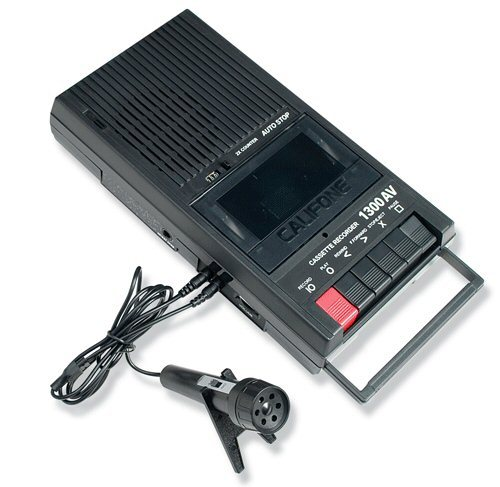

In [61]:
dataset['validation'][0]['image']